# Keras for Text Classification

**Learning Objectives**
1. Learn how to create a text classification datasets using BigQuery
1. Learn how to tokenize and integerize a corpus of text for training in Keras
1. Learn how to do one-hot-encodings in Keras
1. Learn how to use embedding layers to represent words in Keras
1. Learn about the bag-of-word representation for sentences
1. Learn how to use DNN/CNN/RNN model to classify text in keras

## Introduction


In this notebook, we will implement text models to recognize the probable source (GitHub, TechCrunch, or The New York Times) of the titles we have in the title dataset we constructed in the first task of the lab.

In the next step, we will load and pre-process the texts and labels so that they are suitable to be fed to a Keras model. For the texts of the titles we will learn how to split them into a list of tokens, and then how to map each token to an integer using the Keras Tokenizer class. What will be fed to our Keras models will be batches of padded list of integers representing the text. For the labels, we will learn how to one-hot-encode each of the 3 classes into a 3 dimensional basis vector.

Then we will explore a few possible models to do the title classification. All models will be fed padded list of integers, and all models will start with a Keras Embedding layer that transforms the integer representing the words into dense vectors.

The first model will be a simple bag-of-word DNN model that averages up the word vectors and feeds the tensor that results to further dense layers. Doing so means that we forget the word order (and hence that we consider sentences as a “bag-of-words”). In the second and in the third model we will keep the information about the word order using a simple RNN and a simple CNN allowing us to achieve the same performance as with the DNN model but in much fewer epochs.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/keras_for_text_classification.ipynb).

In [1]:
import os

import pandas as pd
from google.cloud import bigquery

In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


Replace the variable values in the cell below:

In [3]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
%env PROJECT = {PROJECT}
%env BUCKET = {PROJECT}
%env REGION = "us-central1"
SEED = 0

env: PROJECT=qwiklabs-asl-03-5d5c0ba6f6d6
env: BUCKET=qwiklabs-asl-03-5d5c0ba6f6d6
env: REGION="us-central1"


## Create a Dataset from BigQuery 

Hacker news headlines are available as a BigQuery public dataset. The [dataset](https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.stories?tab=details) contains all headlines from the sites inception in October 2006 until October 2015. 

### Lab Task 1a: 
Complete the query below to create a sample dataset containing the `url`, `title`, and `score` of articles from the public dataset `bigquery-public-data.hacker_news.stories`. Use a WHERE clause to restrict to only those articles with
* title length greater than 10 characters
* score greater than 10
* url length greater than 0 characters

In [5]:
%%bigquery --project $PROJECT

SELECT
    # TODO: Your code goes here.
    url,
    title,
    score
FROM
    # TODO: Your code goes here.
    `bigquery-public-data.hacker_news.stories`
WHERE
    # TODO: Your code goes here.
    LENGTH(title) > 10 AND
    # TODO: Your code goes here.
    score > 10 AND
    # TODO: Your code goes here.
    LENGTH(url) > 0
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.91rows/s]


,url,title,score
0,http://www.bbc.co.uk/news/business-27732743,Vodafone reveals direct government wiretaps,256
1,https://www.kickstarter.com/projects/appdocu/a...,Doc – App: The Human Story,11
2,http://www.starwebworld.com/android-jelly-bean...,Android Jelly Bean: Streaming Audio Through th...,11
3,http://www.myplanetdigital.com/digital_strateg...,Why Canadian Tech Entrepreneurs Need to Man/Wo...,11
4,http://startupislandconference.com/index.html,"StartupConference June 13. - 16. 2013, HVAR Cr...",11
5,http://kopimism.org/,Kopimism Hactivism Meetup Tomorrow (Sunday) in...,11
6,http://unearthedgadget.com/xbox-live-gold-2/14...,Xbox Live Gold Membership Is It Really Worth -...,11
7,https://evertale.com,Evertale changes the way people remember,11
8,http://www.racketboy.com/retro/commodore-amiga...,Commodore Amiga: A Beginner’s Guide,11
9,http://www.extremetech.com/extreme/156393-cold...,"Cold fusion reactor ""independently verified""",11


Let's do some regular expression parsing in BigQuery to get the source of the newspaper article from the URL. For example, if the url is http://mobile.nytimes.com/...., I want to be left with <i>nytimes</i>

### Lab task 1b:
Complete the query below to count the number of titles within each 'source' category. Note that to grab the 'source' of the article we use the a regex command on the `url` of the article. To count the number of articles you'll use a `GROUP BY` in sql, and we'll also restrict our attention to only those articles whose title has greater than 10 characters.

In [8]:
%%bigquery --project $PROJECT

SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source,
    # TODO: Your code goes here.
    count(title) as num_articles
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$') AND
    # TODO: Your code goes here.
    LENGTH(title) > 10
GROUP BY
    # TODO: Your code goes here.
    source
ORDER BY num_articles DESC
  LIMIT 100

Downloading: 100%|██████████| 100/100 [00:01<00:00, 70.21rows/s]


,source,num_articles
0,blogspot,41386
1,github,36525
2,techcrunch,30891
3,youtube,30848
4,nytimes,28787
...,...,...
95,f5,1254
96,gamasutra,1249
97,cnbc,1229
98,indiatimes,1223


Now that we have good parsing of the URL to get the source, let's put together a dataset of source and titles. This will be our labeled dataset for machine learning.

In [9]:
regex = ".*://(.[^/]+)/"


sub_query = """
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '{0}'), '.'))[OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '{0}'), '.com$')
    AND LENGTH(title) > 10
""".format(
    regex
)


query = """
SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  ({sub_query})
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')
""".format(
    sub_query=sub_query
)

print(query)


SELECT 
    LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title,
    source
FROM
  (
SELECT
    title,
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source
    
FROM
    `bigquery-public-data.hacker_news.stories`
WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
)
WHERE (source = 'github' OR source = 'nytimes' OR source = 'techcrunch')



For ML training, we usually need to split our dataset into training and evaluation datasets (and perhaps an independent test dataset if we are going to do model or feature selection based on the evaluation dataset). AutoML however figures out on its own how to create these splits, so we won't need to do that here. 



In [10]:
bq = bigquery.Client(project=PROJECT)
title_dataset = bq.query(query).to_dataframe()
title_dataset.head()

,title,source
0,feminist-software-foundation complains about r...,github
1,expose sps as web services on the fly.,github
2,show hn scrwl shorthand code reading and wr...,github
3,geoip module on nodejs now is a c addon,github
4,show hn linuxexplorer,github


AutoML for text classification requires that
* the dataset be in csv form with 
* the first column being the texts to classify or a GCS path to the text 
* the last colum to be the text labels

The dataset we pulled from BiqQuery satisfies these requirements.

In [11]:
print(f"The full dataset contains {len(title_dataset)} titles")

The full dataset contains 96203 titles


Let's make sure we have roughly the same number of labels for each of our three labels:

In [12]:
title_dataset.source.value_counts()

github        36525
techcrunch    30891
nytimes       28787
Name: source, dtype: int64

Finally we will save our data, which is currently in-memory, to disk.

We will create a csv file containing the full dataset and another containing only 1000 articles for development.

**Note:** It may take a long time to train AutoML on the full dataset, so we recommend to use the sample dataset for the purpose of learning the tool. 


In [13]:
DATADIR = "./data/"

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [14]:
FULL_DATASET_NAME = "titles_full.csv"
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Let's shuffle the data before writing it to disk.
title_dataset = title_dataset.sample(n=len(title_dataset))

title_dataset.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding="utf-8"
)

Now let's sample 1000 articles from the full dataset and make sure we have enough examples for each label in our sample dataset (see [here](https://cloud.google.com/natural-language/automl/docs/beginners-guide) for further details on how to prepare data for AutoML).

### Lab Task 1c:
Use `.sample` to create a sample dataset of 1,000 articles from the full dataset. Use `.value_counts` to see how many articles are contained in each of the three source categories?

In [16]:
sample_title_dataset = title_dataset.sample(
    n=1000
)  # TODO: Your code goes here.
# TODO: Your code goes here.
sample_title_dataset.source.value_counts()

github        381
techcrunch    333
nytimes       286
Name: source, dtype: int64

Let's write the sample datatset to disk.

In [17]:
SAMPLE_DATASET_NAME = "titles_sample.csv"
SAMPLE_DATASET_PATH = os.path.join(DATADIR, SAMPLE_DATASET_NAME)

sample_title_dataset.to_csv(
    SAMPLE_DATASET_PATH, header=False, index=False, encoding="utf-8"
)

In [18]:
sample_title_dataset.head()

,title,source
45626,white house unbuttons formal dress code,nytimes
94635,alibaba turns 10 aims to create 100 million ...,techcrunch
26368,taking a stanford graduate course in a week,github
31305,show hn miyagi an obj-c json marshaller that...,github
37725,google s bigger cheaper cloud,nytimes


In [19]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Lambda,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

print(tf.__version__)

2.8.0


In [20]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [21]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

Our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, TechCrunch, or The New York Times).

In [22]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ["title", "source"]

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,sshbeam a simple android app that sends files...,github
1,australia joins china in censoring the internet,techcrunch
2,ask show hn upgrading password-hashing scheme...,github
3,cannon.js - a lightweight and simple 3d physic...,github
4,the chains of mental illness in west africa,nytimes


## Integerize the texts

The first thing we need to do is to find how many words we have in our dataset (`VOCAB_SIZE`), how many titles we have (`DATASET_SIZE`), and what the maximum length of the titles we have (`MAX_LEN`) is. Keras offers the `Tokenizer` class in its `keras.preprocessing.text` module to help us with that:

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles_df.title)

In [24]:
integerized_titles = tokenizer.texts_to_sequences(titles_df.title)
integerized_titles[:3]

[[23705, 2, 49, 59, 22, 29, 1941, 162, 3, 2, 776, 118, 330, 739],
 [4248, 857, 140, 5, 11900, 1, 95],
 [657, 11, 12, 7337, 828, 3605, 6447, 215, 260, 17274]]

In [25]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

47271

In [26]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

96203

In [27]:
MAX_LEN = max(len(sequence) for sequence in integerized_titles)
MAX_LEN

26

Let's now implement a function `create_sequence` that will 
* take as input our titles as well as the maximum sentence length and 
* returns a list of the integers corresponding to our tokens padded to the sentence maximum length

Keras has the helper functions `pad_sequence` for that on the top of the tokenizer methods.

### Lab Task #2:
Complete the code in the `create_sequences` function below to
* create text sequences from `texts` using the tokenizer we created above 
* pad the end of those text sequences to have length `max_len`

In [32]:
# TODO 1
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(
        texts
    )  # TODO: Your code goes here.
    padded_sequences = pad_sequences(
        sequences=sequences, maxlen=max_len, padding="post"
    )  # TODO: Your code goes here.
    return padded_sequences

In [33]:
sequences = create_sequences(titles_df.title[:3])
sequences

array([[23705,     2,    49,    59,    22,    29,  1941,   162,     3,
            2,   776,   118,   330,   739,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 4248,   857,   140,     5, 11900,     1,    95,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [  657,    11,    12,  7337,   828,  3605,  6447,   215,   260,
        17274,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [34]:
titles_df.source[:4]

0        github
1    techcrunch
2        github
3        github
Name: source, dtype: object

We now need to write a function that 
* takes a title source and
* returns the corresponding one-hot encoded vector

Keras `to_categorical` is handy for that.

In [35]:
CLASSES = {"github": 0, "nytimes": 1, "techcrunch": 2}
N_CLASSES = len(CLASSES)

### Lab Task #3:
Complete the code in the `encode_labels` function below to
* create a list that maps each `source` in `sources` to its corresponding numeric value using the dictionary `CLASSES` above
* use the Keras function to one-hot encode the variable classes

In [36]:
# TODO 2
def encode_labels(sources):
    classes = [
        CLASSES[source] for source in sources
    ]  # TODO: Your code goes here.
    one_hots = to_categorical(classes)  # TODO: Your code goes here.
    return one_hots

In [37]:
encode_labels(titles_df.source[:4])

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [38]:
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN],
    titles_df.source[:N_TRAIN],
)

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:],
    titles_df.source[N_TRAIN:],
)

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per classes.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.


In [39]:
sources_train.value_counts()

github        29262
techcrunch    24699
nytimes       23001
Name: source, dtype: int64

In [40]:
sources_valid.value_counts()

github        7263
techcrunch    6192
nytimes       5786
Name: source, dtype: int64

Using `create_sequence` and `encode_labels`, we can now prepare the
training and validation data to feed our models.

The features will be
padded list of integers and the labels will be one-hot-encoded 3D vectors.

In [41]:
X_train, Y_train = create_sequences(titles_train), encode_labels(sources_train)
X_valid, Y_valid = create_sequences(titles_valid), encode_labels(sources_valid)

In [42]:
X_train[:3]

array([[23705,     2,    49,    59,    22,    29,  1941,   162,     3,
            2,   776,   118,   330,   739,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 4248,   857,   140,     5, 11900,     1,    95,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [  657,    11,    12,  7337,   828,  3605,  6447,   215,   260,
        17274,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [43]:
Y_train[:3]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

## Building a DNN model

The build_dnn_model function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

### Lab Tasks #4, #5, and #6:
Create a Keras Sequential model with three layers:
* The first layer should be an embedding layer with output dimension equal to `embed_dim`.
* The second layer should use a Lambda layer to create a bag-of-words representation of the sentences by computing the mean.
* The last layer should use a Dense layer to predict which class the example belongs to.

In [45]:
# TODOs 4-6
def build_dnn_model(embed_dim):

    model = Sequential(
        [
            # TODO: Your code goes here.
            Embedding(
                input_dim=VOCAB_SIZE + 1,
                output_dim=embed_dim,
                input_shape=[MAX_LEN],
            ),
            # TODO: Your code goes here.
            Lambda(lambda x: tf.reduce_mean(x, axis=1)),
            # TODO: Your code goes here.
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Below we train the model on 100 epochs but adding an `EarlyStopping` callback that will stop the training as soon as the validation loss has not improved after a number of steps specified by `PATIENCE` . Note that we also give the `model.fit` method a Tensorboard callback so that we can later compare all the models using TensorBoard.

2022-07-21 18:55:57.272602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-07-21 18:55:57.272682: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-21 18:55:57.272723: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hurb-asl): /proc/driver/nvidia/version does not exist
2022-07-21 18:55:57.273302: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
257/257 [==============================] - 3s 9ms/step - loss: 1.0477 - accuracy: 0.4290 - val_loss: 0.9801 - val_accuracy: 0.5354
Epoch 2/100
257/257 [==============================] - 2s 8ms/step - loss: 0.8881 - accuracy: 0.6853 - val_loss: 0.8068 - val_accuracy: 0.7262
Epoch 3/100
257/257 [==============================] - 2s 8ms/step - loss: 0.7335 - accuracy: 0.7836 - val_loss: 0.6831 - val_accuracy: 0.7864
Epoch 4/100
257/257 [==============================] - 2s 8ms/step - loss: 0.6231 - accuracy: 0.8158 - val_loss: 0.5967 - val_accuracy: 0.8027
Epoch 5/100
257/257 [==============================] - 2s 8ms/step - loss: 0.5423 - accuracy: 0.8332 - val_loss: 0.5364 - val_accuracy: 0.8098
Epoch 6/100
257/257 [==============================] - 2s 8ms/step - loss: 0.4834 - accuracy: 0.8441 - val_loss: 0.4934 - val_accuracy: 0.8198
Epoch 7/100
257/257 [==============================] - 2s 9ms/step - loss: 0.4397 - accuracy: 0.8542 - val_loss: 0.4628 - val_accuracy: 0.8288

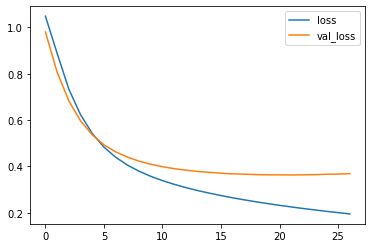

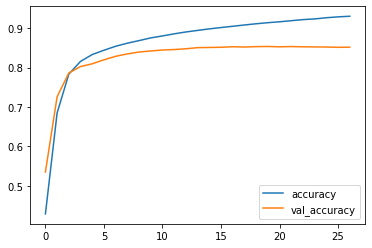

In [46]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "dnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 5

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(dnn_history.history)[["accuracy", "val_accuracy"]].plot()

dnn_model.summary()

## Building a RNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple RNN model with a single `GRU` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


### Lab Task #4 and #6:
Complete the code below to build an RNN model which predicts the article class. The code below is similar to the DNN you created above; however, here we do not need to use a bag-of-words representation of the sentence. Instead, you can pass the embedding layer directly to an RNN/LSTM/GRU layer.

In [49]:
def build_rnn_model(embed_dim, units):

    model = Sequential(
        [
            # TODO: Your code goes here.
            Embedding(
                input_dim=VOCAB_SIZE + 1,
                output_dim=embed_dim,
                input_shape=[MAX_LEN],
                mask_zero=True,
            ),
            # TODO: Your code goes here.
            GRU(units),
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Let's train the model with early stoping as above. 

Observe that we obtain the same type of accuracy as with the DNN model, but in less epochs (~3 v.s. ~20 epochs):

Epoch 1/100
257/257 [==============================] - 16s 42ms/step - loss: 1.0914 - accuracy: 0.3793 - val_loss: 1.0832 - val_accuracy: 0.3775
Epoch 2/100
257/257 [==============================] - 10s 37ms/step - loss: 1.0567 - accuracy: 0.4070 - val_loss: 1.0090 - val_accuracy: 0.5075
Epoch 3/100
257/257 [==============================] - 9s 37ms/step - loss: 0.8638 - accuracy: 0.5976 - val_loss: 0.7368 - val_accuracy: 0.6318
Epoch 4/100
257/257 [==============================] - 9s 37ms/step - loss: 0.6816 - accuracy: 0.6490 - val_loss: 0.6557 - val_accuracy: 0.6481
Epoch 5/100
257/257 [==============================] - 10s 37ms/step - loss: 0.6177 - accuracy: 0.6724 - val_loss: 0.6174 - val_accuracy: 0.6701
Epoch 6/100
257/257 [==============================] - 10s 37ms/step - loss: 0.5817 - accuracy: 0.7065 - val_loss: 0.5956 - val_accuracy: 0.6956
Epoch 7/100
257/257 [==============================] - 9s 37ms/step - loss: 0.5571 - accuracy: 0.7200 - val_loss: 0.5807 - val_accur

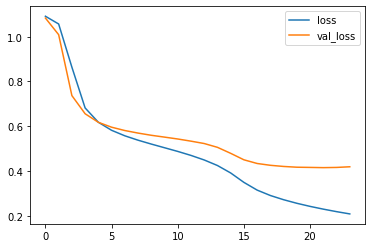

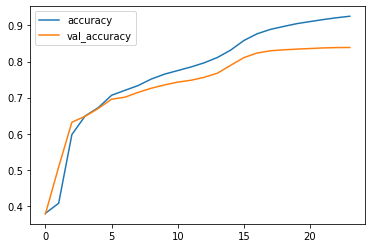

In [50]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "rnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 2

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

rnn_model.summary()

## Build a CNN model

The `build_dnn_model` function below returns a compiled Keras model that implements a simple CNN model with a single `Conv1D` layer, which now takes into account the word order in the sentence.

The first and last layers are the same as for the simple DNN model, but we need to add a `Flatten` layer betwen the convolution and the softmax layer.

Note that we set `mask_zero=True` in the `Embedding` layer so that the padded words (represented by a zero) are ignored by this and the subsequent layers.


### Lab Task #4 and #6
Complete the code below to create a CNN model for text classification. This model is similar to the previous models in that you should start with an embedding layer. However, the embedding next layers should pass through a 1-dimensional convolution and ultimately the final fully connected, dense layer. Use the arguments of the `build_cnn_model` function to set up the 1D convolution layer. 

In [53]:
def build_cnn_model(embed_dim, filters, ksize, strides):

    model = Sequential(
        [
            # TODO: Your code goes here.
            Embedding(
                input_dim=VOCAB_SIZE + 1,
                output_dim=embed_dim,
                input_shape=[MAX_LEN],
                mask_zero=True,
            ),
            # TODO: Your code goes here.
            Conv1D(filters, ksize, strides, activation="relu"),
            # TODO: Your code goes here.
            Flatten(),
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Let's train the model. 

Again we observe that we get the same kind of accuracy as with the DNN model but in many fewer steps.



Epoch 1/100
257/257 [==============================] - 4s 14ms/step - loss: 1.0792 - accuracy: 0.4029 - val_loss: 1.0400 - val_accuracy: 0.4802
Epoch 2/100
257/257 [==============================] - 3s 13ms/step - loss: 0.9165 - accuracy: 0.5873 - val_loss: 0.7850 - val_accuracy: 0.6460
Epoch 3/100
257/257 [==============================] - 3s 13ms/step - loss: 0.6868 - accuracy: 0.6836 - val_loss: 0.6316 - val_accuracy: 0.6977
Epoch 4/100
257/257 [==============================] - 3s 13ms/step - loss: 0.5819 - accuracy: 0.7314 - val_loss: 0.5716 - val_accuracy: 0.7362
Epoch 5/100
257/257 [==============================] - 3s 13ms/step - loss: 0.5229 - accuracy: 0.7732 - val_loss: 0.5307 - val_accuracy: 0.7634
Epoch 6/100
257/257 [==============================] - 3s 13ms/step - loss: 0.4728 - accuracy: 0.8051 - val_loss: 0.4944 - val_accuracy: 0.7882
Epoch 7/100
257/257 [==============================] - 3s 13ms/step - loss: 0.4278 - accuracy: 0.8300 - val_loss: 0.4639 - val_accuracy:

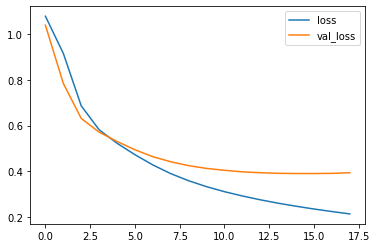

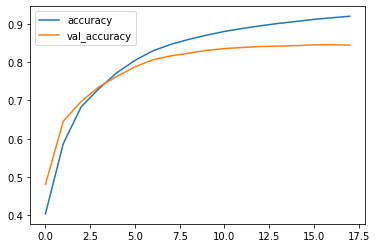

In [54]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "cnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 2


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(cnn_history.history)[["accuracy", "val_accuracy"]].plot()

cnn_model.summary()

## (Optional) Using the Keras Text Preprocessing Layer

Thanks to the new Keras preprocessing layer, we can also include the preprocessing of the text (i.e., the tokenization followed by the integer representation of the tokens) within the model itself as a standard Keras layer. Let us first import this text preprocessing layer:

In [55]:
from keras.layers import TextVectorization

At instanciation, we can specify the maximum length of the sequence output as well as the maximum number of tokens to be considered:

In [56]:
MAX_LEN = 26
MAX_TOKENS = 20000
preprocessing_layer = TextVectorization(
    output_sequence_length=MAX_LEN, max_tokens=MAX_TOKENS
)

Before using this layer in our model, we need to adapt it to our data so that it generates a token-to-integer mapping. Remeber our dataset looks like the following:

In [57]:
titles_df.head()

,title,source
0,sshbeam a simple android app that sends files...,github
1,australia joins china in censoring the internet,techcrunch
2,ask show hn upgrading password-hashing scheme...,github
3,cannon.js - a lightweight and simple 3d physic...,github
4,the chains of mental illness in west africa,nytimes


We can directly use the Pandas Series corresponding to the titles in our dataset to adapt the data using the `adapt` method:

In [58]:
preprocessing_layer.adapt(titles_df.title)

At this point, the preprocessing layer can create the integer representation of our input text if we simply apply the layer to it:

In [59]:
X_train, X_valid = titles_train, titles_valid
X_train[:5]

0    sshbeam  a simple android app that sends files...
1      australia joins china in censoring the internet
2    ask show hn  upgrading password-hashing scheme...
3    cannon.js - a lightweight and simple 3d physic...
4          the chains of mental illness in west africa
Name: title, dtype: object

In [60]:
integers = preprocessing_layer(X_train[:5])
integers

<tf.Tensor: shape=(5, 26), dtype=int64, numpy=
array([[    1,     4,    47,    58,    22,    27,  1888,   151,     3,
            4,   761,   115,   310,   719,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 4325,   799,   125,     6, 13759,     2,    89,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [  642,    12,    13,  7315,     1,  6478,   200,   277,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    1,     4,   330,     8,    47,   306,  1744,   120,     5,
            2,    25,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    2,  5344,     7,  3115,  5041,     6,  2121,  2205,     0,
            0,     0,     0,     0,     0,     0,     

**Exercise:** In the following cell, implement a function
`build_model_with_text_preprocessing(embed_dim, units)` that returns a text model with the following sequential structure:

1. the `preprocessing_layer` we defined above folowed by
1. an embedding layer with `embed_dim` dimension for the output vectors followed by
1. a GRU layer with `units` number of neurons followed by
1. a final dense layer for classification

In [76]:
def build_model_with_text_preprocessing(embed_dim, units):

    # TODO
    model = Sequential(
        [
            tf.keras.layers.Input(shape=(1,), dtype=tf.string),
            preprocessing_layer,
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True
            ),
            GRU(units),
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

Our model is now able to cosume text directly as input! Again, consider the following text sample:

In [62]:
X_train[:5]

0    sshbeam  a simple android app that sends files...
1      australia joins china in censoring the internet
2    ask show hn  upgrading password-hashing scheme...
3    cannon.js - a lightweight and simple 3d physic...
4          the chains of mental illness in west africa
Name: title, dtype: object

Then we can have our model directly predict on this input:





In [68]:
print(UNITS)

16


In [77]:
model = build_model_with_text_preprocessing(embed_dim=EMBED_DIM, units=UNITS)
model.predict(X_train[:5])

array([[0.33454305, 0.33374736, 0.33170956],
       [0.3312122 , 0.33293074, 0.33585706],
       [0.33616787, 0.33384115, 0.329991  ],
       [0.33166906, 0.33292583, 0.33540505],
       [0.33268794, 0.3377822 , 0.32952988]], dtype=float32)

Of course the model above has not yet been trained, so its prediction are meaningless so far. Let us train it now on our dataset as before:

Epoch 1/100
257/257 [==============================] - 17s 45ms/step - loss: 0.4789 - accuracy: 0.7863 - val_loss: 0.3767 - val_accuracy: 0.8461
Epoch 2/100
257/257 [==============================] - 10s 39ms/step - loss: 0.2836 - accuracy: 0.8877 - val_loss: 0.3758 - val_accuracy: 0.8495
Epoch 3/100
257/257 [==============================] - 10s 39ms/step - loss: 0.2195 - accuracy: 0.9157 - val_loss: 0.4195 - val_accuracy: 0.8434
Epoch 4/100
257/257 [==============================] - 10s 39ms/step - loss: 0.1767 - accuracy: 0.9327 - val_loss: 0.4399 - val_accuracy: 0.8430
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 26)               0         
 torization)                                                     
                                                                 
 embedding_11 (Embedding)    (None, 26, 10)            472720    
 

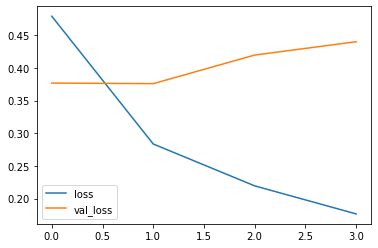

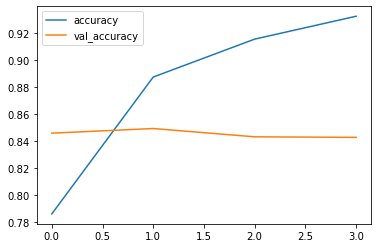

In [78]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "rnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 2

model = build_model_with_text_preprocessing(embed_dim=EMBED_DIM, units=UNITS)

history = model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

model.summary()

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License